In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lmfit as lm

In [16]:
egfp = pd.read_excel('data-siRNA/2017_06_02_seq6_Huh7_controll_#molecules.xlsx',sheet="#GFP_corrected")

In [17]:
egfp_d = egfp.dropna().values.T

In [18]:
time = egfp_d[0].astype(np.double)

In [19]:
egfp_data = egfp_d[1:].astype(np.double)

Text(0,0.5,'# of RFP molecules')

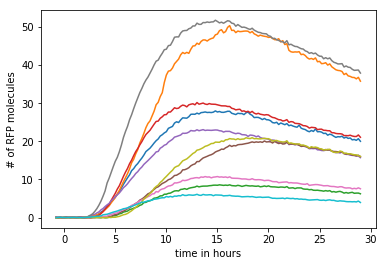

In [20]:
for data in egfp_data[:10]:
    plt.plot(time,data)
plt.xlabel('time in hours')
plt.ylabel('# of RFP molecules')

In [21]:
def egfp_expression(t,ktm,delta,beta,t0):
    result = ktm/(delta-beta)*(1-np.exp(-(delta-beta)*(t-t0)))*np.exp(-beta*(t-t0))
    result[t<t0] = 0
    return result

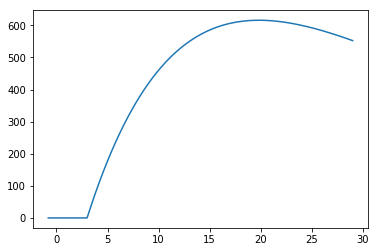

In [31]:
plt.plot(time,egfp_expression(time,100,0.07,0.05,3))

In [23]:
egfp_model = lm.Model(egfp_expression)

In [24]:
data = egfp_data[0]
sigma = np.sqrt(np.abs(egfp_data[0]))
sigma[sigma<=0] = 1.0

In [41]:
pars = egfp_model.make_params()

pars['ktm'].set(value=6,vary=True,min=0)
pars['delta'].set(value=0.07,vary=True,min=0)
pars['beta'].set(value=0.05,vary=True,min=0)
pars['t0'].set(value=4,vary=True,min=0)

result = egfp_model.fit(data,pars,t=time)

print(result.fit_report())

p = result.params


[[Model]]
    Model(egfp_expression)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 150
    # variables        = 4
    chi-square         = 61.3146350
    reduced chi-square = 0.41996325
    Akaike info crit   = -126.192510
    Bayesian info crit = -114.149969
[[Variables]]
    ktm:    6.40014669 +/- 0.12889546 (2.01%) (init = 6)
    delta:  0.10661284 +/- 0.01673399 (15.70%) (init = 0.07)
    beta:   0.06663294 +/- 0.01114780 (16.73%) (init = 0.05)
    t0:     4.10479484 +/- 0.04603231 (1.12%) (init = 4)
[[Correlations]] (unreported correlations are < 0.100)
    C(delta, beta) = -0.996
    C(ktm, delta)  =  0.920
    C(ktm, beta)   = -0.885
    C(ktm, t0)     =  0.763
    C(delta, t0)   =  0.616
    C(beta, t0)    = -0.571



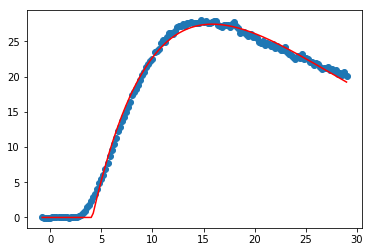

In [26]:
plt.plot(time,data,"o")
plt.plot(time,result.best_fit,'r-')

In [32]:
def chisqTwoStage(t,data,delta,beta,t0,ktm):
    time = t-t0
    time_2na = time[:,np.newaxis,np.newaxis]
    middle = 1 - np.exp(-(delta-beta)*time_2na)
    last = np.exp(-beta*time_2na)
    first = ktm/(delta-beta)
    y = first*middle*last
    res = (data - y.T).T
    return np.sum(res**2,axis=0)

/Users/hstrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/hstrey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


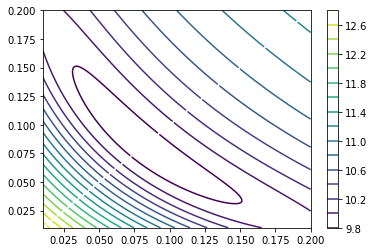

In [46]:
beta = np.linspace(0.01,0.2,201)
delta = np.linspace(0.01,0.2,201)

B,D = np.meshgrid(beta,delta)

chi2 = np.log(chisqTwoStage(time,data,D,B,p['t0'].value,p['ktm'].value))

plt.contour(B,D,chi2,20)
plt.colorbar()